# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

## Import Libraries

In [68]:
import sys
import math

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
# import torchjd
# from torchjd.aggregation import UPGrad

# from torchviz import make_dot

from pinn_loss_t2 import loss_fn_data, l1_regularization, pde_loss, boundary_loss, ic_loss, accuracy
from Input_vec_gen import input_gen


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation

### Define the constants and inital geometric domain

In [69]:
# Geometry
length = 15.0e-3             # Length of the rod

# Material properties
rho = 2300.0                     # Density of AL380 (kg/m^3)
rho_l = 2460.0                   # Density of AL380 (kg/m^3)
rho_s = 2710.0                    # Density of AL380 (kg/m^3)
rho_m = (rho_l + rho_s )/2       # Desnity in mushy zone is taken as average of liquid and solid density

k = 104.0                       # W/m-K
k_l = k                       # W/m-K
k_s = 96.2                    # W/m-K
k_m =  (k_l+k_s)/2                     # W/m-K
k_mo = 41.5


cp = 1245.3                      # Specific heat of aluminum (J/kg-K)
cp_l = cp                      # Specific heat of aluminum (J/kg-K)
cp_s = 963.0                 # Specific heat of aluminum (J/kg-K)
cp_m =  (cp_l+cp_s)/2                 # Specific heat of mushy zone is taken as average of liquid and solid specific heat
# cp_m = cp
           # Thermal diffusivity
alpha_l = k_l / (rho_l * cp_l) 
alpha_s = k_s / (rho_s*cp_s)
alpha_m = k_m / (rho_m * cp_m)          #`Thermal diffusivity in mushy zone is taken as average of liquid and solid thermal diffusivity`


#L_fusion = 3.9e3                 # J/kg
L_fusion = 389.0e3               # J/kg  # Latent heat of fusion of aluminum
         # Thermal diffusivity


T_L = 574.4 +273.0                       #  K -Liquidus Temperature (615 c) AL 380
T_S = 497.3 +273.0                     # K- Solidus Temperature (550 C)
m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
print (f"alpha_l = {alpha_l}, alpha_s = {alpha_s}, m_eff = {m_eff}")

# htc = 10.0                   # W/m^2-K
# q = htc*(919.0-723.0)
# q = 10000.0


num_points = 50                        # Number of spatial points
dx = length / (num_points - 1)         # Distance between two spatial points
print('dx is',dx)

                                                              
# Time Discretization  
# 
time_end = 40        # seconds                         

maxi = max(alpha_s,alpha_l,alpha_m)
dt = abs(0.5*((dx**2) /maxi)) 

print('dt is ',dt)
num_steps = round(time_end/dt)
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/max(alpha_l,alpha_s,alpha_m))
print('cfl is',cfl)

time_steps = np.linspace(0, time_end, num_steps + 1)
step_coeff = dt / (dx ** 2)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

alpha_l = 3.394878564540885e-05, alpha_s = 3.686205086349929e-05, m_eff = 6.296953764744878e-06
dx is 0.0003061224489795918
dt is  0.0012711033647622566
num_steps is 31469
cfl is 0.0012711033647622566
stability criteria satisfied


### Initial and Boundary Conditions

In [70]:

temp_init = 919.0
# Initial temperature and phase fields
temperature = np.full(num_points+2, 919.0)            # Initial temperature of the rod with ghost points at both ends
phase = np.zeros(num_points+2)*0.0                    # Initial phase of the rod with ghost points at both ends

# Set boundary conditions
# temperature[-1] = 919.0 
phase[-1] = 1.0

# temperature[0] = 919.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]    # List to store temperature at each time step
phi_history = [phase.copy()]                    # List to store phase at each time step
temp_init = temperature.copy()                 # Initial temperature of the rod
# print(temperature_history,phi_history)
# Array to store temperature at midpoint over time
midpoint_index = num_points // 2                          # Index of the midpoint

midpoint_temperature_history = [temperature[midpoint_index]]            # List to store temperature at midpoint over time
dm = 60.0e-3                                                            # die thickness in m

# r_m =  (k_mo / dm) + (1/htc)
 
t_surr = 500.0                                        # Surrounding temperature in K
# t_surr = h()



def kramp(temp,v1,v2,T_L,T_s):                                      # Function to calculate thermal conductivity in Mushy Zone
        slope = (v1-v2)/(T_L-T_S)
        if temp > T_L:
            k_m = k_l
        elif temp < T_S:
            k_m = k_s
        else:
            k_m = k_s + slope*(temp-T_S)
        return k_m

def cp_ramp(temp,v1,v2,T_L,T_s):                                    # Function to calculate specific heat capacity in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        cp_m = cp_l
    elif temp < T_S:
        cp_m = cp_s
    else:
        cp_m = cp_s + slope*(temp-T_S)
    return cp_m

def rho_ramp(temp,v1,v2,T_L,T_s):                                       # Function to calculate density in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        rho_m = rho_l
    elif temp < T_S:
        rho_m = rho_s
    else:
        rho_m = rho_s + slope*(temp-T_S)
    return rho_m

### Solving the HT equation and phase change numerically

In [71]:

for m in range(1, num_steps+1):                                                                            # time loop
    htc = 10.0                   # htc of Still air in W/m^2-K
    q1 = htc*(temp_init[0]-t_surr)   # Heat flux at the left boundary
    
    # print(f"q1 is {q1}")
    temperature[0] = temp_init[0] + alpha_l * step_coeff * ((2.0*temp_init[1]) - (2.0 * temp_init[0])-(2.0*dx*(q1)))  # Update boundary condition temperature
    
    q2 = htc*(temp_init[-1]-t_surr)                   # Heat flux at the right boundary
    temperature[-1] = temp_init[-1] + alpha_l * step_coeff * ((2.0*temp_init[-2]) - (2.0 * temp_init[-1])-(2.0*dx*(q2)))  # Update boundary condition temperature
    
    for n in range(1,num_points+1):              # space loop, adjusted range
       
        if temperature[n] >= T_L:
            temperature[n] += ((alpha_l * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
            phase[n] = 0
            
            # print(f" Time-Step{m},Spatial point{n},Temperature{temperature[n]}")
        elif T_S < temperature[n] < T_L:
            
            k_m = kramp(temperature[n],k_l,k_s,T_L,T_S)
            cp_m = cp_ramp(temperature[n],cp_l,cp_s,T_L,T_S)
            rho_m = rho_ramp(temperature[n],rho_l,rho_s,T_L,T_S)
            m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
            # print(m_eff)
            temperature[n] += ((m_eff * step_coeff)* (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
            
            phase[n] = (T_L - temperature[n]) / (T_L - T_S)
            # print(m,n,temperature[n],phase[n])
         
        elif temperature[n]<=T_S:
            temperature[n] += ((alpha_s * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n])+ temp_init[n-1]))
            phase[n] = 1
                     
        else:
            print("ERROR: should not be here")

     
          
    temperature = temperature.copy()                                                                # Update temperature
    phase = phase.copy()                                                                            # Update phase
    temp_init = temperature.copy()                                                                  # Update last time step temperature
    temperature_history.append(temperature.copy())                                                  # Append the temperature history to add ghost points
    phi_history.append(phase.copy())                                                                # Append the phase history to add ghost points
    midpoint_temperature_history.append(temperature[midpoint_index])                                # Store midpoint temperature
    
    
    # print(f"Step {m}, Temperature: {temperature}")
    


# print(midpoint_temperature_history)
#print(phi_history)





### Plot the Results

(31470, 52)


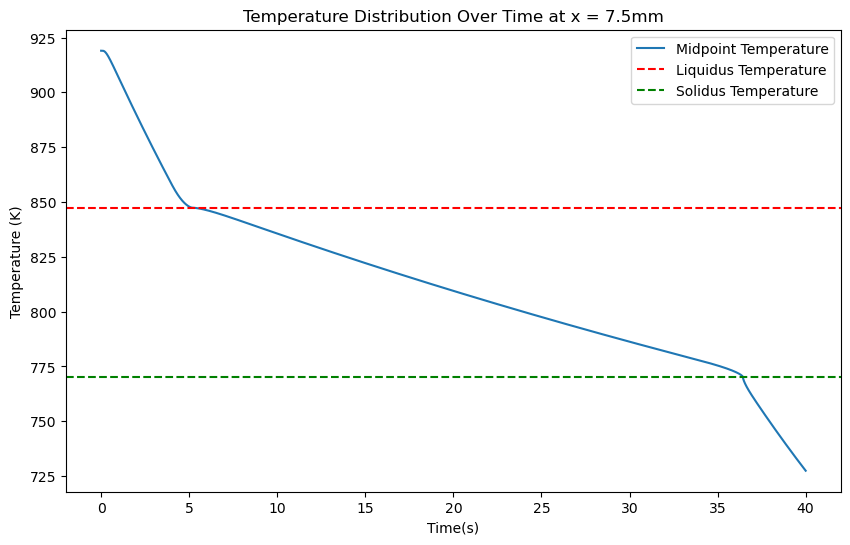

In [72]:
# Plot temperature history for debugging
temperature_history_1 = np.array(temperature_history)
print(temperature_history_1.shape)
time_ss= np.linspace(0, time_end, num_steps+1)
# print(time_ss.shape)
plt.figure(figsize=(10, 6))
plt.plot(time_ss, midpoint_temperature_history, label='Midpoint Temperature')
plt.axhline(y=T_L, color='r', linestyle='--', label='Liquidus Temperature')
plt.axhline(y=T_S, color='g', linestyle='--', label='Solidus Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution Over Time at x = 7.5mm') 
plt.legend()
plt.show()

### Data into Array

In [73]:
temperature_history = np.array(temperature_history)

phi_history = np.array(phi_history)

t_hist = np.array(temperature_history)  # Remove ghost points
# p_hist = np.array(phi_history[:,1:-1])
# t_pde = t_hist[1:,1:-1]                # Remove initial condition and boundary condition
# # t_pde = t_pde.flatten()
# t_hist_init = t_hist[0,:]
# t_hist_bc_l = t_hist[:,0]
# t_hist_bc_r = t_hist[:,-1]

print(t_hist.shape)

scaler_temp = StandardScaler()
t_hist_tr= scaler_temp.fit_transform(t_hist.reshape(-1,1)) # Normalize temperature history
t_prep = t_hist_tr.reshape(num_steps+1,num_points+2)
print(t_prep.shape)
t_pde = t_prep[1:,2:-2]
t_init = t_prep[0,:]
t_bc_l = t_prep[:,0]
t_bc_r = t_prep[:,-1]

t_pde = t_pde.flatten() 
t_init = t_init.flatten()
t_bc_l = t_bc_l.flatten()
t_bc_r = t_bc_r.flatten()

temp_init_t = t_init[3]

temp_mean = scaler_temp.mean_
temp_scale = scaler_temp.scale_

def temp_transform(temp):
    return (temp - temp_mean) / temp_scale

T_Lt = temp_transform(T_L)
T_St = temp_transform(T_S)
t_surrt = temp_transform(t_surr)


(31470, 52)
(31470, 52)


## ML training

### GPU/CPU check

In [74]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Data preparation

In [75]:



space = np.linspace(0, length, num_points+2) # Spatial points
time = np.linspace(0, time_end, num_steps+1) # Time points

space, time = np.meshgrid(space, time)

scaler1 = StandardScaler()
scaler2 = StandardScaler()

space = scaler1.fit_transform(space.reshape(-1,1)) # Normalize spatial points
time = scaler2.fit_transform(time.reshape(-1,1)) # Normalize time points

space = space.reshape(num_steps+1,num_points+2)
time = time.reshape(num_steps+1,num_points+2)

print(space.shape,time.shape)

sp_pde = space[1:,2:-2] # Spatial points
time_pde = time[1:,2:-2]
print(sp_pde.shape,time_pde.shape)

sp_i = space[0,:]   
time_i = time[0,:]

sp_b_l = space[:,0]
time_b_l = time[:,0]

sp_b_r = space[:,-1]
time_b_r = time[:,-1]


space = space.flatten()
time = time.flatten()

sp_pde = sp_pde.flatten()
time_pde = time_pde.flatten()

sp_i = sp_i.flatten()
time_i = time_i.flatten()

sp_b_l = sp_b_l.flatten()
time_b_l = time_b_l.flatten()

sp_b_r = sp_b_r.flatten()
time_b_r = time_b_r.flatten()



print(space.shape,time.shape)






(31470, 52) (31470, 52)
(31469, 48) (31469, 48)
(1636440,) (1636440,)


In [76]:
inputs = np.column_stack((space, time)) # Input vector
inputs_pde = np.column_stack((sp_pde, time_pde)) # Input vector for PDE
inputs_init = np.column_stack((sp_i, time_i)) # Input vector for initial condition
inputs_bc_l = np.column_stack((sp_b_l, time_b_l)) # Input vector for left boundary condition
inputs_bc_r = np.column_stack((sp_b_r, time_b_r)) # Input vector for right boundary condition

print(inputs.shape,inputs_pde.shape,inputs_init.shape,inputs_bc_l.shape,inputs_bc_r.shape)

(1636440, 2) (1510512, 2) (52, 2) (31470, 2) (31470, 2)


In [77]:
# Convert the inputs to a tensor



inputs = torch.tensor(inputs).float().to(device)
inputs_pde = torch.tensor(inputs_pde).float().to(device)
inputs_init = torch.tensor(inputs_init).float().to(device) 
inputs_b_l = torch.tensor(inputs_bc_l).float().to(device)
inputs_b_r = torch.tensor(inputs_bc_r).float().to(device)
print(inputs.dtype)


# print(inputs_init[:5,:])
# label/temp data to tensor
temp_tr = torch.tensor(t_hist_tr).float().to(device) # Convert the temperature history to a tensor
temp_inp = temp_tr.reshape(-1,1).float().to(device) # Reshape the temperature tensor to a column vector
temp_pde = torch.tensor(t_pde).float().to(device) # Convert the temperature history to a tensor
temp_inp_init = torch.tensor(t_init).float().to(device) # Convert the temperature history to a tensor
temp_inp_bc_l = torch.tensor(t_bc_l).float().to(device)# Convert the temperature history to a tensor
temp_inp_bc_r = torch.tensor(t_bc_r).float().to(device)# Convert the temperature history to a tensor




#Data Splitting

# train_inputs, val_test_inputs, train_temp_inp, val_test_temp_inp = train_test_split(inputs, temp_inp, test_size=0.2, random_state=42)
# val_inputs, test_inputs, val_temp_inp, test_temp_inp = train_test_split(val_test_inputs, val_test_temp_inp, test_size=0.8, random_state=42)

train_inputs, test_inputs, train_temp_inp, test_temp_inp = train_test_split(inputs, temp_inp,test_size=0.2, random_state=42)
train_inputs_pde, test_inputs_pde, train_temp_inp_pde, test_temp_inp_pde = train_test_split(inputs_pde, temp_pde,\
                                                                                             test_size=0.2, random_state=42)
train_inputs_init, test_inputs_init, train_temp_inp_init, test_temp_inp_init = train_test_split(inputs_init, temp_inp_init, \
                                                                                                test_size=0.2, random_state=42)
train_inputs_bc_l, test_inputs_bc_l, train_temp_inp_bc_l, test_temp_inp_bc_l = train_test_split(inputs_b_l, temp_inp_bc_l, \
                                                                                                 test_size=0.2, random_state=42)
train_inputs_bc_r, test_inputs_bc_r, train_temp_inp_bc_r, test_temp_inp_bc_r = train_test_split(inputs_b_r, temp_inp_bc_r, \
                                                                                                test_size=0.2, random_state=42)

# print(train_inputs.shape, test_inputs.shape, train_temp_inp.shape, test_temp_inp.shape)


torch.float32


### Create Data loader

In [78]:
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, temp_inp,transform=None, target_transform =None):
        self.inputs = inputs
        self.temp_inp = temp_inp

    def __getitem__(self, index):
        return self.inputs[index], self.temp_inp[index]
    
    def __len__(self):
        return len(self.inputs)

  
train_dataset = TensorDataset(train_inputs, train_temp_inp) # Create the training dataset
# val_dataset = TensorDataset(val_inputs, val_temp_inp) # Create the validation dataset
test_dataset = TensorDataset(test_inputs, test_temp_inp) # Create the test dataset

train_dataset_pde = TensorDataset(train_inputs_pde, train_temp_inp_pde) # Create the training dataset
test_dataset_pde = TensorDataset(test_inputs_pde, test_temp_inp_pde) # Create the test dataset

train_dataset_init = TensorDataset(train_inputs_init, train_temp_inp_init) # Create the training dataset
test_dataset_init = TensorDataset(test_inputs_init, test_temp_inp_init) # Create the test dataset
train_dataset_bc_l = TensorDataset(train_inputs_bc_l, train_temp_inp_bc_l) # Create the training dataset
test_dataset_bc_l = TensorDataset(test_inputs_bc_l, test_temp_inp_bc_l) # Create the test dataset
train_dataset_bc_r = TensorDataset(train_inputs_bc_r, train_temp_inp_bc_r) # Create the training dataset
test_dataset_bc_r = TensorDataset(test_inputs_bc_r, test_temp_inp_bc_r) # Create the test dataset


batch_size = 256
batch_size_s =1000

random_sampler_train = RandomSampler(train_dataset, replacement=True, num_samples=batch_size_s) # Create a random sampler for the training dataset
# random_sampler_val = RandomSampler(val_dataset, replacement=True, num_samples=batch_size) # Create a random sampler for the validation dataset
random_sampler_test = RandomSampler(test_dataset, replacement=True, num_samples=batch_size_s) # Create a random sampler for the test dataset

random_sampler_train_pde = RandomSampler(train_dataset_pde, replacement=True, num_samples=batch_size_s) # Create a random sampler for the training dataset
random_sampler_test_pde = RandomSampler(test_dataset_pde, replacement=True, num_samples=batch_size_s) # Create a random sampler for the test dataset


random_sampler_train_init = RandomSampler(train_dataset_init, replacement=True, num_samples=50) # Create a random sampler for the training dataset
random_sampler_test_init = RandomSampler(test_dataset_init, replacement=True, num_samples=50) # Create a random sampler for the test dataset
random_sampler_train_bc_l = RandomSampler(train_dataset_bc_l, replacement=True, num_samples=batch_size_s) # Create a random sampler for the training dataset
random_sampler_test_bc_l = RandomSampler(test_dataset_bc_l, replacement=True, num_samples=batch_size_s) # Create a random sampler for the test dataset
random_sampler_train_bc_r = RandomSampler(train_dataset_bc_r, replacement=True, num_samples=batch_size_s) # Create a random sampler for the training dataset
random_sampler_test_bc_r = RandomSampler(test_dataset_bc_r, replacement=True, num_samples=batch_size_s) # Create a random sampler for the test dataset





train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=random_sampler_train) # Create the training dataloader
# val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=random_sampler_val) # Create the validation dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=random_sampler_test) # Create the test dataloader

train_loader_pde = DataLoader(train_dataset_pde, batch_size=batch_size, sampler=random_sampler_train_pde) # Create the training dataloader
test_loader_pde = DataLoader(test_dataset_pde, batch_size=batch_size, sampler=random_sampler_test_pde) # Create the test dataloader

train_loader_init = DataLoader(train_dataset_init, batch_size=5, sampler=random_sampler_train_init) # Create the training dataloader
test_loader_init = DataLoader(test_dataset_init, batch_size=5, sampler=random_sampler_test_init) # Create the test dataloader

train_loader_bc_l = DataLoader(train_dataset_bc_l, batch_size=batch_size, sampler=random_sampler_train_bc_l) # Create the training dataloader
test_loader_bc_l = DataLoader(test_dataset_bc_l, batch_size=batch_size, sampler=random_sampler_test_bc_l) # Create the test dataloader
train_loader_bc_r = DataLoader(train_dataset_bc_r, batch_size=batch_size, sampler=random_sampler_train_bc_r) # Create the training dataloader
test_loader_bc_r = DataLoader(test_dataset_bc_r, batch_size=batch_size, sampler=random_sampler_test_bc_r) # Create the test dataloader



### NN Architecture Definition

In [79]:

# Define the neural network architecture
class Mushydata(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,hidden_layers,hidden_layers_2): # This is the constructor
        super(Mushydata, self).__init__()
        layers =[]

        layers.append(nn.Linear(input_size, hidden_size)) # First layer
        layers.append(nn.Tanh()) # Activation function

        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())

        for _ in range(hidden_layers_2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_size, output_size)) # Output layer
        self.base = nn.Sequential(*layers)
        
    def forward(self, x, t):                               # This is the forward pass
        input_features = torch.cat([x, t], dim=1)          # Concatenate the input features
        m = self.base(input_features)                                 # Pass through the third layer
        return m                    # Return the output of the network


# features = torch.rand(1, 2)
# model = HeatPINN(2, 20, 1)
# output = model(features[:, 0:1], features[:, 1:2])
# print(output)


# Loss function for data 


### Hyperparamters Init

In [80]:
# Hyperparameters
hidden_size = 40
learning_rate = 0.006
epochs = 100
# alpha = 0.01  # Adjust this value based on your problem
# boundary_value = 313.0
# initial_value = init_temp
# Initialize the model
model = Mushydata(input_size=2, hidden_size=hidden_size,output_size=1,hidden_layers=4,hidden_layers_2=4).to(device)
lambd = 0.1

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



### Loss List Init

In [81]:
train_losses = []
val_losses = []
test_losses = []

print(f"Datatype of train_loader is {type(train_loader)}")



Datatype of train_loader is <class 'torch.utils.data.dataloader.DataLoader'>


### Loss functions

### Training, Validation and Testing Module

In [82]:
def training_loop(epochs, model, loss_fn_data, optimizer, train_dataloader,train_loader_pde,\
                  test_dataloader,train_loader_init,\
                  train_loader_bc_l,train_loader_bc_r):
    train_losses = []  # Initialize the list to store the training losses
    # val_losses = []    # Initialize the list to store the validation losses
    test_losses = []   # Initialize the list to store the test losses
    data_losses = []   # Initialize the list to store the data losses
    pde_losses = []   # Initialize the list to store the PDE losses
    ic_losses = []   # Initialize the list to store the initial condition losses
    bc_losses = []   # Initialize the list to store the boundary condition losses

    for epoch in range(epochs):
        model.train()                                                                           # Set the model to training mode
        train_loss = 0                                                                              # Initialize the training loss
        data_loss = 0
        data_loss_b = 0
        phy_loss = 0
        init_loss = 0
      
        for (batch,batch_pde,batch_init,batch_left,batch_right) in \
             zip (train_dataloader,train_loader_pde,train_loader_init,train_loader_bc_l,\
                  train_loader_bc_r):                                                          # Loop through the training dataloader
            
            inputs, temp_inp= batch                                                             # Get the inputs and the true values
            inputs_pde, temp_inp_pde= batch_pde                                                             # Get the inputs and the true values
            inputs_init, temp_inp_init= batch_init                                                             # Get the inputs and the true values 
            inputs_left, temp_inp_left= batch_left                                                             # Get the inputs and the true values
            inputs_right, temp_inp_right= batch_right                                                             # Get the inputs and the true values

            inputs, temp_inp= inputs.to(device), temp_inp.to(device)                             # Move the inputs and true values to the GPU
            inputs_pde, temp_inp_pde= inputs_pde.to(device), temp_inp_pde.to(device)                             # Move the inputs and true values to the GPU
            
            inputs_init, temp_inp_init= inputs_init.to(device), temp_inp_init.to(device)                             # Move the initial condition inputs and temperature to the GPU
            
            inputs_left, temp_inp_left= inputs_left.to(device), temp_inp_left.to(device)                             # Move the left boundary condition inputs and temperature values to the GPU
            inputs_right, temp_inp_right= inputs_right.to(device), temp_inp_right.to(device)                             # Move the right boundary condition inputs and temperature values to the GPU
            
            
            optimizer.zero_grad()                                                                    # Zero the gradients
            
            # Forward pass
            u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1)).to(device)                       # Get the predictions
                                 

            u_initl = model(inputs_init[:,0].unsqueeze(1), inputs_init[:,1].unsqueeze(1)).to(device)                       # Get the predictions
            
            u_left = model(inputs_b_l[:,0].unsqueeze(1), inputs_b_l[:,1].unsqueeze(1)).to(device)               # Left boundary of the temperature
            u_right = model(inputs_b_r[:,0].unsqueeze(1), inputs_b_r[:,1].unsqueeze(1)).to(device)             # Right boundary of the temperature
            
            # Loss calculation
            data_loss = loss_fn_data(u_pred, temp_inp)                                              # Calculate the data loss
            
            phy_loss = pde_loss(model,inputs_pde[:,0].unsqueeze(1),inputs_pde[:,1].unsqueeze(1),T_St,T_Lt)             # Calculate the PDE loss
            
           
            init_loss = ic_loss(u_initl,temp_init_t) 
                                                             # Calculate initial condition loss
            
            bc_loss_left = boundary_loss(model,inputs_b_l[:,0].unsqueeze(1),inputs_b_l[:,1].unsqueeze(1),t_surrt) # Calculate the left boundary condition loss
            bc_loss_right = boundary_loss(model,inputs_b_r[:,0].unsqueeze(1),inputs_b_r[:,1].unsqueeze(1),t_surrt) # Calculate the right boundary condition loss
            bc_loss = bc_loss_left + bc_loss_right
            # bc_loss = 0
            w0 = 0
            w1 = 1
            w2 = 0
            w3 = 0
            loss = w0*data_loss + w1 *phy_loss + w2 * init_loss + w3 * bc_loss
            # print(loss)
                                                                         # Calculate the total loss
            # Backpropagation
            loss.backward(retain_graph=True)                                                       # Backpropagate the gradients
            
            # torchjd.backward([data_loss,pd_loss], model.parameters(), A)

            optimizer.step()                                                                           # Update the weights
            
            train_loss += loss.item()                                                           # Add the loss to the training set loss  
            data_loss_b += data_loss.item()              
            phy_loss += phy_loss.item()
            init_loss += init_loss.item()
            # bc_losses.append(bc_loss.item())
        
        # graph = make_dot(loss, params=dict(model.named_parameters()))
        # graph.format = 'png'

        # graph.render('graph')
        
        
        train_losses.append(train_loss /len(train_dataloader))                                                   # Append the training loss to the list of training losses
        
        data_losses.append(data_loss /len(train_dataloader))                                                   # Append the training loss to the list of training losses
        pde_losses.append(phy_loss /len(train_loader_pde))                                                   # Append the training loss to the list of training losses
        ic_losses.append(init_loss /len(train_loader_init))                                                   # Append the training loss to the list of training losses
        
        
        model.eval()
        test_loss = 0
        
        # with torch.no_grad():   
        for batch in test_dataloader:
            inputs, temp_inp= batch
            inputs, temp_inp= inputs.to(device), temp_inp.to(device)
            u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))
            data_loss_t = loss_fn_data(u_pred, temp_inp)
            # l1_regularization_loss = l1_regularization(model, lambd)
            # loss = data_loss  + l1_regularization_loss
            loss = data_loss_t
            test_accuracy = accuracy(u_pred, temp_inp)
            test_loss += loss.item()
        test_losses.append(test_loss)
        
        torch.cuda.empty_cache()
        
        if epoch % 10 == 0:
            print(f"| Epoch {epoch},            | Training-Loss {train_loss:.4e},| Test-Loss {test_loss:.4e}   |")
            print(f"--"*40)
            print(f"| Data-loss {data_loss:.4e},| pde-loss {phy_loss:.4e},        | initc-loss {init_loss:.4e},|bc_loss {bc_loss:.4e}|") 
    

    return train_losses, test_losses , pde_losses , bc_losses , ic_losses, data_losses                                                      # Return the training and validation losses


In [83]:
def test_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader):
      
    model.eval()
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():   
        for batch in test_dataloader:
            inputs, temp_inp= batch
            inputs, temp_inp= inputs.to(device), temp_inp.to(device)
            u_pred = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1))
            data_loss = loss_fn_data(u_pred, temp_inp)
            # l1_regularization_loss = l1_regularization(model, lambd)
            # loss = data_loss  + l1_regularization_loss
            loss = data_loss
            test_accuracy = accuracy(u_pred, temp_inp)
            test_loss += loss.item()
        test_losses.append(test_loss)
    if epochs % 10 == 0:
        print(f"Epoch {epochs}, Test-Loss {test_loss:.4e}, Test-Accuracy {test_accuracy:.4e}")      
    return test_losses

### Training Button 

In [84]:
torch.autograd.set_detect_anomaly(True)
train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs, model, loss_fn_data, optimizer,train_loader,train_loader_pde,\
                    test_loader,train_loader_init,\
                  train_loader_bc_l,train_loader_bc_r)  # Train the model
 
# test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_loader, test_loader)  # Test the model


   


    
    

| Epoch 0,            | Training-Loss 1.5272e-04,| Test-Loss 3.7340e+00   |
--------------------------------------------------------------------------------
| Data-loss 1.0680e+00,| pde-loss 2.0002e-06,        | initc-loss 1.6861e+01,|bc_loss 1.2993e+04|
| Epoch 10,            | Training-Loss 7.9828e-08,| Test-Loss 4.1608e+00   |
--------------------------------------------------------------------------------
| Data-loss 9.4886e-01,| pde-loss 7.6716e-08,        | initc-loss 1.7786e+01,|bc_loss 1.2737e+04|
| Epoch 20,            | Training-Loss 3.2129e-09,| Test-Loss 4.1416e+00   |
--------------------------------------------------------------------------------
| Data-loss 9.8179e-01,| pde-loss 9.1426e-10,        | initc-loss 1.7773e+01,|bc_loss 1.2740e+04|
| Epoch 30,            | Training-Loss 1.0575e-09,| Test-Loss 4.3625e+00   |
--------------------------------------------------------------------------------
| Data-loss 9.0237e-01,| pde-loss 5.8887e-10,        | initc-loss 1.7773e+0

## Plots

(1636440, 1)


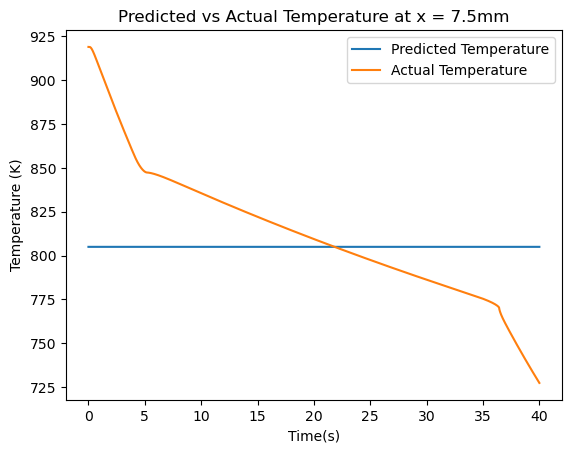

In [85]:
temp_nn = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model
print(temp_nn.shape)
temp_nn = scaler_temp.inverse_transform(temp_nn) # Inverse transform the predictions
temp_nn = temp_nn.reshape(num_steps+1, num_points+2) # Reshape the predictions to a 2D array
time_ss= np.linspace(0, time_end, num_steps+1 )

plt.figure
plt.plot(time_ss, temp_nn[:, num_points//2], label='Predicted Temperature')
plt.plot(time_ss, temperature_history[:,num_points//2], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.yscale('linear')
plt.title('Predicted vs Actual Temperature at x = 7.5mm')
plt.legend()
plt.show()


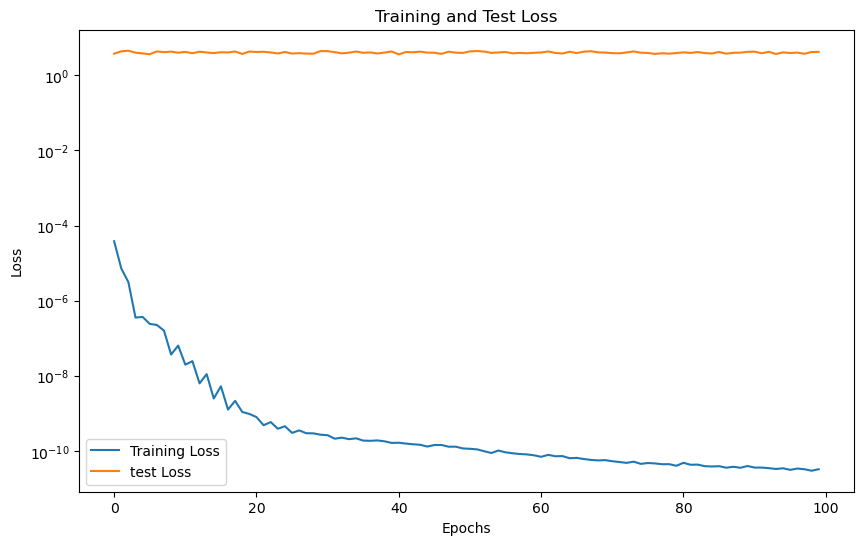

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

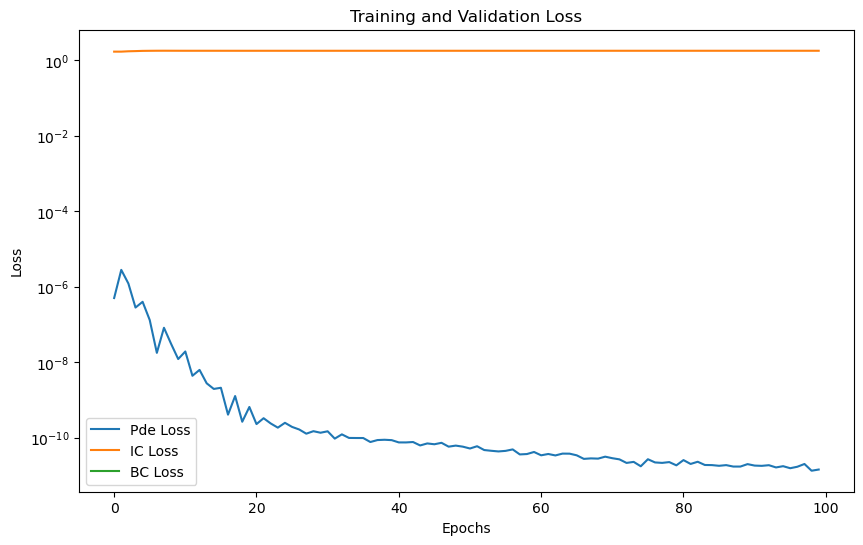

In [87]:
data_losses = [data_losses.cpu().detach().numpy() for data_losses in data_losses]
pde_losses = [pde_losses.cpu().detach().numpy() for pde_losses in pde_losses]
ic_losses = [ic_losses.cpu().detach().numpy() for ic_losses in ic_losses]
bc_losses = [bc_losses.cpu().detach().numpy() for bc_losses in bc_losses]


plt.figure(figsize=(10, 6))
# plt.plot(data_losses, label='Data Loss')
plt.plot(pde_losses, label='Pde Loss')
plt.plot(ic_losses, label='IC Loss')
plt.plot(bc_losses, label='BC Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

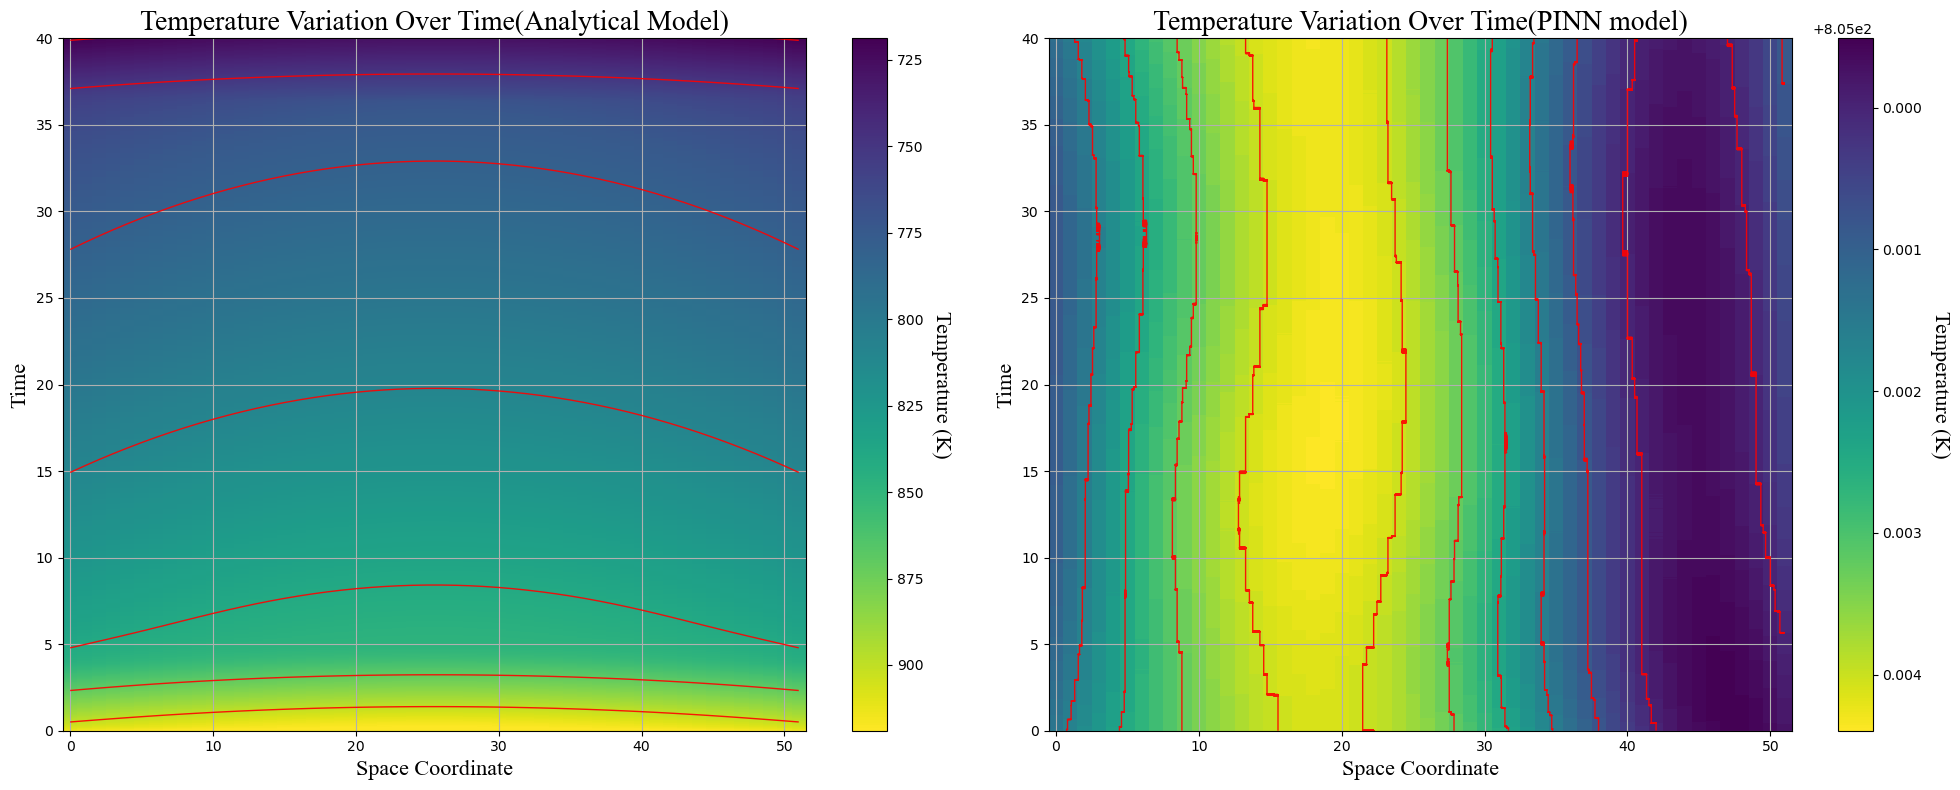

In [88]:
space_coord, time_coord = np.meshgrid(np.arange(t_hist.shape[1]), np.arange(t_hist.shape[0]))

time_coord = time_coord * dt 
# Create a figure with two subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, t_hist, cmap='viridis', shading='auto')
ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax1.set_title('Temperature Variation Over Time(Analytical Model)',fontname='Times New Roman', fontsize=20)
ax1.contour(space_coord, time_coord, t_hist, colors='red', linewidths=1.0, alpha=0.9)

ax1.grid(True)
cbar = fig.colorbar(im1, ax=ax1)
cbar.ax.invert_yaxis()
cbar.set_label('Temperature (K)', rotation=270, labelpad=20, fontname='Times New Roman', fontsize=16)

im2 = ax2.pcolormesh(space_coord, time_coord, temp_nn, cmap='viridis', shading='auto')
ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax2.set_title('Temperature Variation Over Time(PINN model)',fontname='Times New Roman', fontsize=20)
ax2.contour(space_coord, time_coord, temp_nn, colors='red', linewidths=1.0, alpha=0.9)

ax2.grid(True)
cbar = fig.colorbar(im2, ax=ax2)
cbar.ax.invert_yaxis()
cbar.set_label('Temperature (K)', rotation=270, labelpad=20, fontname='Times New Roman', fontsize=16)


plt.tight_layout()
plt.show()
